Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Opening video: /content/drive/MyDrive/retail_challenge/videos/1_1_crop.mp4
Processing video: /content/drive/MyDrive/retail_challenge/videos/1_1_crop.mp4
Video has 3920 frames. Adjusted range: 156 to 183
Extracted 28 frames
Processing video: /content/drive/MyDrive/retail_challenge/videos/1_1_crop.mp4
Video has 3920 frames. Adjusted range: 184 to 211
Extracted 28 frames
Processing video: /content/drive/MyDrive/retail_challenge/videos/1_1_crop.mp4
Video has 3920 frames. Adjusted range: 217 to 371
Extracted 18 frames
Processing video: /content/drive/MyDrive/retail_challenge/videos/1_1_crop.mp4
Video has 3920 frames. Adjusted range: 376 to 406
Extracted 31 frames
Processing video: /content/drive/MyDrive/retail_challenge/videos/1_1_crop.mp4
Video has 3920 frames. Adjusted range: 406 to 416
Extracted 11 frames
Process

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Opening video for inference: /content/drive/MyDrive/retail_challenge/videos/1_1_crop.mp4
Processing video: /content/drive/MyDrive/retail_challenge/videos/1_1_crop.mp4
Video has 3920 frames. Adjusted range: 156 to 183
Extracted 28 frames
Action from frame 156 to 183: Predicted Retract from Shelf, True Reach to Shelf
Processing video: /content/drive/MyDrive/retail_challenge/videos/1_1_crop.mp4
Video has 3920 frames. Adjusted range: 184 to 211
Extracted 28 frames
Action from frame 184 to 211: Predicted Retract from Shelf, True Retract from Shelf
Processing video: /content/drive/MyDrive/retail_challenge/videos/1_1_crop.mp4
Video has 3920 frames. Adjusted range: 217 to 371
Extracted 18 frames
Action from frame 217 to 371: Predicted Retract from Shelf, True Inspect Product
Processing video: /content/drive/MyDrive/retail_challenge/videos/1_1_crop.mp4
Video has 3920 frames. Adjusted range: 376 to 406
Extracted 31 frames
Action from frame 376 to 406: Predicted Retract from Shelf, True Reach to 

<Figure size 1200x600 with 0 Axes>

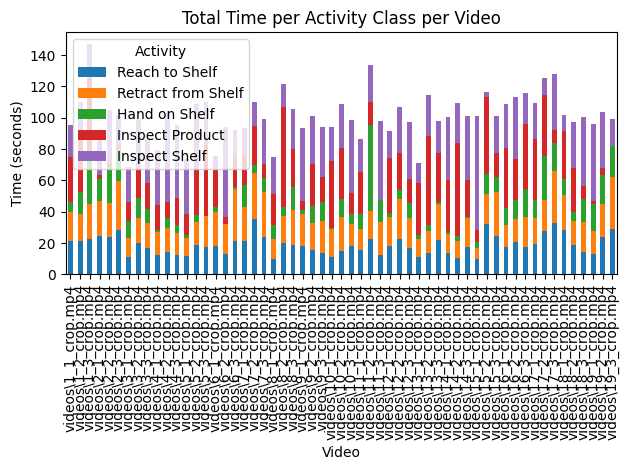

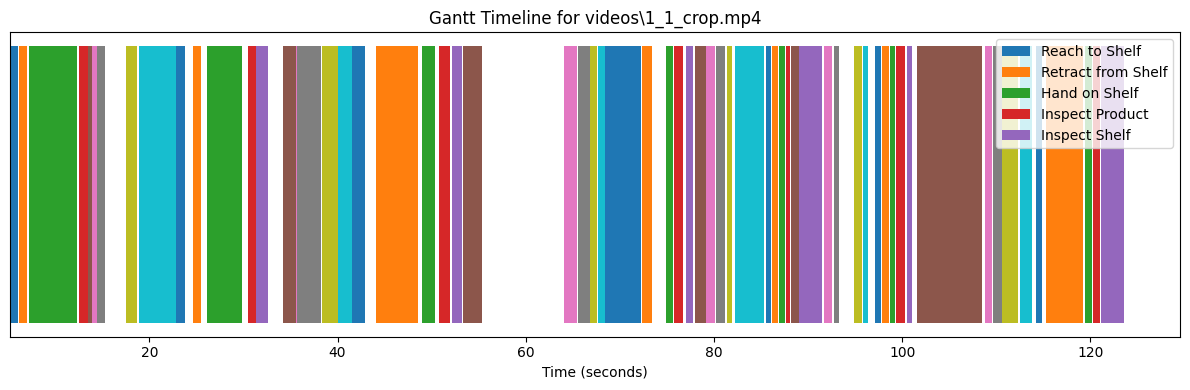

Total notebook runtime: 1216.10 seconds (20.27 minutes)
Success: Total runtime is under 25 minutes!


In [2]:

# runtime measurement
import time
total_start_time = time.time()

# Install dependencies
!pip install tensorflow opencv-python-headless matplotlib pandas seaborn

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import numpy as np
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Load annotations
with open('/content/annotations.json', 'r') as f:
    annotations = json.load(f)

# Activity labels Definations
labels = {
    0: 'Reach to Shelf',
    1: 'Retract from Shelf',
    2: 'Hand on Shelf',
    3: 'Inspect Product',
    4: 'Inspect Shelf'
}

# Extract video frames using an existing VideoCapture object
def extract_frames_with_cap(cap, video_path, start_frame, end_frame, fps=30, max_frames=16):
    print(f"Processing video: {video_path}")
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Clamp frame range to valid bounds
    start_frame = max(0, min(start_frame, total_frames - 1))
    end_frame = max(0, min(end_frame, total_frames - 1))
    if start_frame > end_frame:
        start_frame, end_frame = end_frame, start_frame  # Swap if invalid
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    print(f"Video has {total_frames} frames. Adjusted range: {start_frame} to {end_frame}")
    if start_frame >= total_frames or end_frame < 0:
        print(f"Error: Frame range {start_frame}-{end_frame} out of bounds for video with {total_frames} frames")
        return np.zeros((max_frames, 224, 224, 3))
    step = max(1, (end_frame - start_frame + 1) // max_frames)
    for frame_idx in range(start_frame, end_frame + 1, step):
        ret, frame = cap.read()
        if not ret:
            print(f"Warning: Could not read frame {frame_idx}")
            break
        frame = cv2.resize(frame, (224, 224))
        frame = frame / 255.0
        frames.append(frame)
    print(f"Extracted {len(frames)} frames")
    if len(frames) == 0:
        print(f"Error: No frames extracted from {video_path} for range {start_frame}-{end_frame}")
        return np.zeros((max_frames, 224, 224, 3))
    if len(frames) < max_frames:
        frames.extend([frames[-1]] * (max_frames - len(frames)))
    elif len(frames) > max_frames:
        frames = frames[:max_frames]
    return np.array(frames)

# Training data for fine-tuning
def prepare_training_data(annotations, video_dir, max_segments=30):  # used 30
    data = []
    labels_list = []
    for video in annotations['videos'][:2]:
        video_filename = video['file'].replace('videos\\', '').replace('videos/', '')
        video_path = os.path.join(video_dir, video_filename)
        print(f"Opening video: {video_path}")
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video file {video_path}")
            cap.release()
            continue
        for action in video['actions']:
            frames = extract_frames_with_cap(cap, video_path, action['start_frame'], action['end_frame'], max_frames=16)
            if np.all(frames == 0):
                print(f"Skipping action in {video['file']} due to failed frame extraction")
                continue
            data.append(frames)
            labels_list.append(action['label_id'])
            if len(data) >= max_segments:
                break
        cap.release()
        if len(data) >= max_segments:
            break
    if len(data) == 0:
        raise ValueError("No valid training data could be extracted. Check video paths and frame ranges.")
    return np.array(data), np.array(labels_list)

# Load and fine-tune MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True

# Build model with TimeDistributed to process frames
inputs = tf.keras.Input(shape=(16, 224, 224, 3))  # [frames, height, width, channels]
x = tf.keras.layers.TimeDistributed(base_model)(inputs)  # Apply MobileNetV2 to each frame
x = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling2D())(x)  # Reduce spatial dimensions
x = tf.keras.layers.LSTM(128)(x)  # Aggregate temporal features
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)  # 5 activity classes
model = tf.keras.Model(inputs, outputs)

# Model COmpilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune on a small dataset
video_dir = '/content/drive/MyDrive/retail_challenge/videos/'
X_train, y_train = prepare_training_data(annotations, video_dir, max_segments=30)
model.fit(X_train, y_train, epochs=2, batch_size=4, verbose=1)

# fine-tuned weights
model.save_weights('/content/mobilenetv2_finetuned.weights.h5')
from google.colab import files
files.download('/content/mobilenetv2_finetuned.weights.h5')

# Classify video segment
def classify_segment(frames, model):
    frames = tf.convert_to_tensor(frames, dtype=tf.float32)
    frames = tf.expand_dims(frames, axis=0)
    probabilities = model(frames)
    predicted_label = tf.argmax(probabilities, axis=1).numpy()[0]
    return predicted_label

# Time-and-motion analysis
def calculate_action_durations(annotations, fps=30):
    video_stats = []
    for video in annotations['videos']:
        video_name = video['file']
        actions = video['actions']
        duration_stats = {label: 0.0 for label in labels.values()}
        for action in actions:
            label = labels[action['label_id']]
            duration = (action['end_frame'] - action['start_frame'] + 1) / fps
            duration_stats[label] += duration
        video_stats.append({
            'video': video_name,
            **duration_stats
        })
    return pd.DataFrame(video_stats)

# Process videos
start_time = time.time()
video_subset = annotations['videos'][:5]
for video in video_subset:
    video_filename = video['file'].replace('videos\\', '').replace('videos/', '')
    video_path = os.path.join(video_dir, video_filename)
    print(f"Opening video for inference: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        cap.release()
        continue
    for action in video['actions']:
        start_frame = action['start_frame']
        end_frame = action['end_frame']
        frames = extract_frames_with_cap(cap, video_path, start_frame, end_frame, max_frames=16)
        if np.all(frames == 0):
            print(f"Skipping action in {video['file']} due to failed frame extraction")
            continue
        predicted_label = classify_segment(frames, model)
        print(f"Action from frame {start_frame} to {end_frame}: Predicted {labels[predicted_label]}, True {labels[action['label_id']]}")
    cap.release()
print(f"Inference runtime: {time.time() - start_time:.2f} seconds")

# Calculate durations
df_stats = calculate_action_durations(annotations)

# Visualizations
plt.figure(figsize=(12, 6))
df_stats.set_index('video')[list(labels.values())].plot(kind='bar', stacked=True)
plt.title('Total Time per Activity Class per Video')
plt.xlabel('Video')
plt.ylabel('Time (seconds)')
plt.legend(title='Activity')
plt.tight_layout()
plt.savefig('/content/stacked_bar.png')
plt.show()

# Gantt-style Timeline for first video
video = annotations['videos'][0]
actions = video['actions']
plt.figure(figsize=(12, 4))
for i, action in enumerate(actions):
    start_time = action['start_frame'] / 30
    end_time = action['end_frame'] / 30
    plt.barh(y=0, left=start_time, width=end_time - start_time, label=labels[action['label_id']])
plt.title(f'Gantt Timeline for {video["file"]}')
plt.xlabel('Time (seconds)')
plt.yticks([])
plt.legend(labels.values(), loc='upper right')
plt.tight_layout()
plt.savefig('/content/gantt_timeline.png')
plt.show()

# Save results
df_stats.to_csv('/content/activity_durations.csv')

# Total runtime
total_runtime = time.time() - total_start_time
print(f"Total notebook runtime: {total_runtime:.2f} seconds ({total_runtime / 60:.2f} minutes)")
if total_runtime > 1500:
    print("Warning: Total runtime exceeds 25 minutes!")
else:
    print("Success: Total runtime is under 25 minutes!")

In [ ]:
# Configure Git
!git config --global user.email "dotunodude@gmail.com"
!git config --global user.name "fernabache"

# Authenticate with GitHub
from getpass import getpass
token = getpass('Enter your GitHub token: ')
repo_url = f'https://{token}@github.com/fernabache/retail-challenge.git'

# Clone the repository
!git clone {repo_url}

# Copy deliverables to the repository folder
!cp /content/drive/MyDrive/retail_challenge/retail_challenge.ipynb /content/retail-challenge/
!cp /content/activity_durations.csv /content/retail-challenge/
!cp /content/stacked_bar.png /content/retail-challenge/
!cp /content/gantt_timeline.png /content/retail-challenge/
!cp /content/mobilenetv2_finetuned.weights.h5 /content/retail-challenge/
!cp /content/drive/MyDrive/retail_challenge/README.md /content/retail-challenge/
!cp /content/drive/MyDrive/retail_challenge/report.pdf /content/retail-challenge/

# Commit and push
%cd /content/retail-challenge
!git add .
!git commit -m "Add retail challenge deliverables (final submission)"
!git push origin main